In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
import random

def show_images(images, per_row=2, main_title=None):
    figure = plt.figure(1)

    for n, img in enumerate(images):
        ax = figure.add_subplot(np.ceil(len(images) / per_row), per_row, n + 1)

        ax.grid(False)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        plt.axis("off")

        plt.imshow(img)
    if main_title is not None:
        plt.suptitle(main_title)

    plt.show()

# Exploring The Data Set

Vehicle Images:
   Count:       8792 of 17760 (49.50%)
   Value Range: 0 to 255
   Shape:       64 x 64


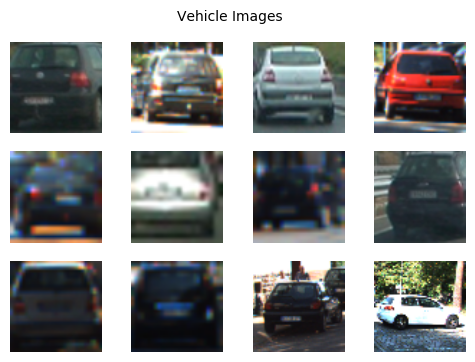



Non Vehicle Images:
   Count:       8968 of 17760 (50.50%)
   Value Range: 0 to 255
   Shape:       64 x 64


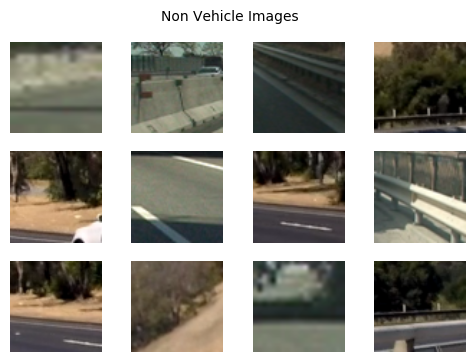

In [6]:
from features import DataLoader


def explore_data(title, data, total_count, image_sample_count=12):
    count = len(data)
    percentage_of_total = count * 100.0 / total_count
    shape = data[0].shape
    minmax_range = (np.amin(data), np.amax(data))
    
    print('{:s}:'.format(title))
    print('   Count:       {:d} of {:d} ({:3.2f}%)'.format(count, total_count, percentage_of_total))
    print('   Value Range: {} to {}'.format(minmax_range[0], minmax_range[1]))
    print('   Shape:       {} x {}'.format(shape[0], shape[1]))
    
    sample_images = []
    for i in range(0, image_sample_count):
        sample_images.append(random.choice(data))
        
    show_images(sample_images, per_row=4, main_title=title)
    
    return count, shape, minmax_range

# load vehicle and non vehicle data
loader = DataLoader()
vehicle_data = loader.load_data(path="vehicles/**/*.png")
non_vehicle_data = loader.load_data(path="non-vehicles/**/*.png")

# compute total number of features
image_count = len(vehicle_data) + len(non_vehicle_data)

# show details about each data set
result = explore_data("Vehicle Images", vehicle_data, image_count)
print("")
print("")
result = explore_data("Non Vehicle Images", non_vehicle_data, image_count)

# Evaluating Support Vector Color Classifier 

In [7]:
# from features import FeatureExtractor
from features import SupportVectorClassifier

featureExtractor = FeatureExtractor()

# color and binning parameters
bins = (32)
# bins = (64)
# sizes = ((32,32), (24,24), (16,16))
sizes = ((32,32))
# colorspaces = ('RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb')
colorspaces = ('HSV')

# hog parameters
orientation_configs = (6, 9, 12)
pix_per_cells_configs = (4, 8, 12)
cells_per_block_configs = (1,2,3)

number_of_times_for_average = 1
results = {}
for bin_count in bins:
    for size in sizes:
        for colorspace in colorspaces:
            for orientation in orientation_configs:
                for pix_per_cell in pix_per_cells_configs:
                    for cells_per_block in cells_per_block_configs:
                        total_score = 0
                        for times in range(0,number_of_times_for_average):
                            vehicle_features = featureExtractor.extract_features(vehicle_data, 
                                                                                 colorspace=colorspace, 
                                                                                 spatial_size=size,
                                                                                 hist_bins=bin_count,
                                                                                 orientations=orientation,
                                                                                 pixels_per_cell=pix_per_cell,
                                                                                 cells_per_block=cells_per_block)

                            non_vehicle_features = featureExtractor.extract_features(non_vehicle_data, 
                                                                                 colorspace=colorspace, 
                                                                                 spatial_size=size,
                                                                                 hist_bins=bin_count,
                                                                                 orientations=orientation,
                                                                                 pixels_per_cell=pix_per_cell,
                                                                                 cells_per_block=cells_per_block)

                            classifier = SupportVectorClassifier(vehicle_features, non_vehicle_features)
                            total_score += classifier.train_and_score(test_size=0.2)

                        args = "colspace: {}, size: {}, bins: {}, orientation: {}, pix/cell: {}, cells/block: {}".format(colorspace, size, bin_count, orientation, pix_per_cell, cells_per_block)        
                        results[args] = total_score / number_of_times_for_average
                        print("{:.5f}".format(total_score/number_of_times_for_average), "==>", args)

print("")
print("TOP 10 CONFIGURATIONS")
# show top 10 results and the arguments that produces them
for r in sorted(results, key=results.get, reverse=True)[:10]:
    print(r, results[r])

print("Done")

NameError: name 'FeatureExtractor' is not defined

In [ ]:
colorspace = 'HSV'
size = (32,32)
bins = 16
orientation = 9
pix_per_cell = 4
cells_per_block = 1

number_of_times_for_average = 5

for times in range(0,number_of_times_for_average):
    vehicle_features = featureExtractor.extract_features(vehicle_data, 
                                                        colorspace=colorspace, 
                                                        spatial_size=size,
                                                        hist_bins=bins)

    non_vehicle_features = featureExtractor.extract_features(non_vehicle_data, 
        colorspace=colorspace, 
        spatial_size=size,
        hist_bins=bins)

    classifier = SupportVectorClassifier(vehicle_features, non_vehicle_features)
    total_score += classifier.train_and_score(test_size=0.2)

    args = "colspace: {}, size: {}, bins: {}, orientation: {}, pix/cell: {}, cells/block: {}".format(colorspace, size, bin_count, orientation, pix_per_cell, cells_per_block)        
    results[args] = total_score / number_of_times_for_average
    print("{:.5f}".format(total_score/number_of_times_for_average), "==>", args)

In [ ]:
classifier = SupportVectorClassifier(vehicle_features, non_vehicle_features)
score = classifier.train_and_score(test_size=0.2)
print(score)

In [ ]:
results = []
for i in range(0,10):
    vehicle_features = featureExtractor.extract_features(vehicle_data, 
                                                                 colorspace='YCrCb', 
                                                                 spatial_size=(16,16),
                                                                 hist_bins=48)
            
    non_vehicle_features = featureExtractor.extract_features(non_vehicle_data, 
                                                                 colorspace='YCrCb', 
                                                                 spatial_size=(16,16),
                                                                 hist_bins=48)
            
    classifier = SupportVectorClassifier(vehicle_features, non_vehicle_features)
    score = classifier.train_and_score(test_size=0.2)
    results.append(score)
    
print(np.mean(results))
        

In [ ]:
test = [10,1,5,6,10,10,10]
print(np.mean(test))

In [ ]:
0.99268 ==> colspace: HSV, size: (32, 32), bins: 16, orientation: 9, pix/cell: 4, cells/block: 1